In [2]:
!pip install --upgrade pandas pyarrow

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Lee el archivo .gzip que contiene el parquet directamente
df = pd.read_parquet('bermejales.gzip')

# Muestra las primeras filas de la tabla para verificar
print(df.head())

              datetime         co      no2      o3  pm10     tmp      vv
0  2005-01-01 00:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
1  2005-01-01 01:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2  2005-01-01 02:00:00  2024.6667  26.6667  7.5000   NaN  6.6667  1.0000
3  2005-01-01 03:00:00  2229.3333  19.6667  5.5000   NaN  6.1667  0.3333
4  2005-01-01 04:00:00  2096.1667  19.5000  4.6667   NaN  5.3333  0.8333


## VARIABLES

### Contaminantes:

**NO2: (Dióxido de nitrógeno)**:
- Origen principal: Tráfico rodado y combustión (vehículos, calefacción, industria).
- Más alto en horas punta (7–9h, 18–20h) por tráfico.
- Más bajo por la noche y fines de semana.
- Relaciones:
    - Temperatura: tiende a disminuir cuando la temperatura sube, porque hay más mezcla del aire (dispersión vertical).

    - Viento (vv): el viento dispersa los contaminantes → a más viento, menos NO₂.

    - PM₁₀: correlación positiva, porque ambos suelen tener origen en el tráfico.

    - O₃: anticorrelación — el ozono se forma cuando los óxidos de nitrógeno (NOx) reaccionan con luz solar; si hay mucho NO₂, se “consume” ozono. Los picos de NO2 coinciden con los mínimos de O3.

**O3 (Ozono troposférico)**:

- No se emite directamente, se forma fotoquímicamente a partir de NO₂ + compuestos orgánicos volátiles bajo radiación solar.

- Mínimos de noche (sin luz solar).

- Máximos a mediodía y por la tarde (más radiación UV).

- Más alto en verano, más bajo en invierno.

- Relaciones:

    - Temperatura: más calor = más radiación y reacciones fotoquímicas → más O₃.

    - NO₂: relación inversa (NO consume O₃).

    - Viento: el viento puede diluir O₃ localmente, aunque también puede transportarlo desde otras zonas rurales.

    - PM₁₀: a veces correlaciona en verano (ambos altos por condiciones estables).

**PM10 (Material particulado ≤10 μm)**:

- Origen: tráfico (frenado, desgaste), polvo en suspensión, calefacción, industria.

- Relaciones:

    - Viento: suele disminuir con viento fuerte (dispersión), pero si el viento viene de zonas áridas puede aumentarlo (polvo sahariano).

    - Temperatura: en días fríos con inversión térmica, el aire se estratifica → aumenta PM₁₀ (no se dispersa).

    - NO₂: suelen correlacionar (ambos del tráfico).

    - O₃: a veces correlación positiva en verano (ambos asociados a alta radiación y estabilidad atmosférica).


### Variables adicionales:

**Temperatura (tmp)**:

- Relaciones típicas:

    - Con NO₂ y PM₁₀ en invierno → más calor → más dispersión → menos contaminantes.

    - Con O₃ → más calor → más formación fotoquímica.

    - A menudo se ve que los contaminantes primarios bajan con la temperatura, mientras que los secundarios (como O₃) suben.

**Viento (vv)**:
- Efecto general: dispersa contaminantes → reduce concentraciones locales.
- Relaciones:
    - Disminuye las concentraciones de NO₂ y PM₁₀.

    - Puede aumentar la de O₃ si el viento proviene de zonas donde se genera.

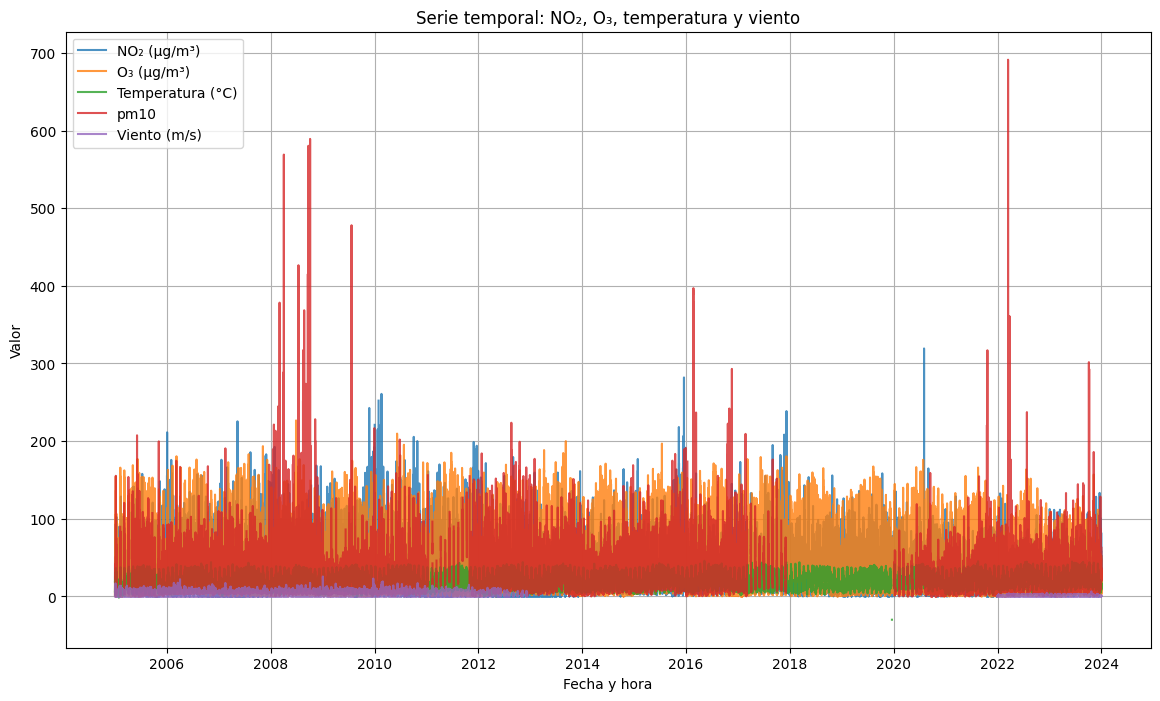

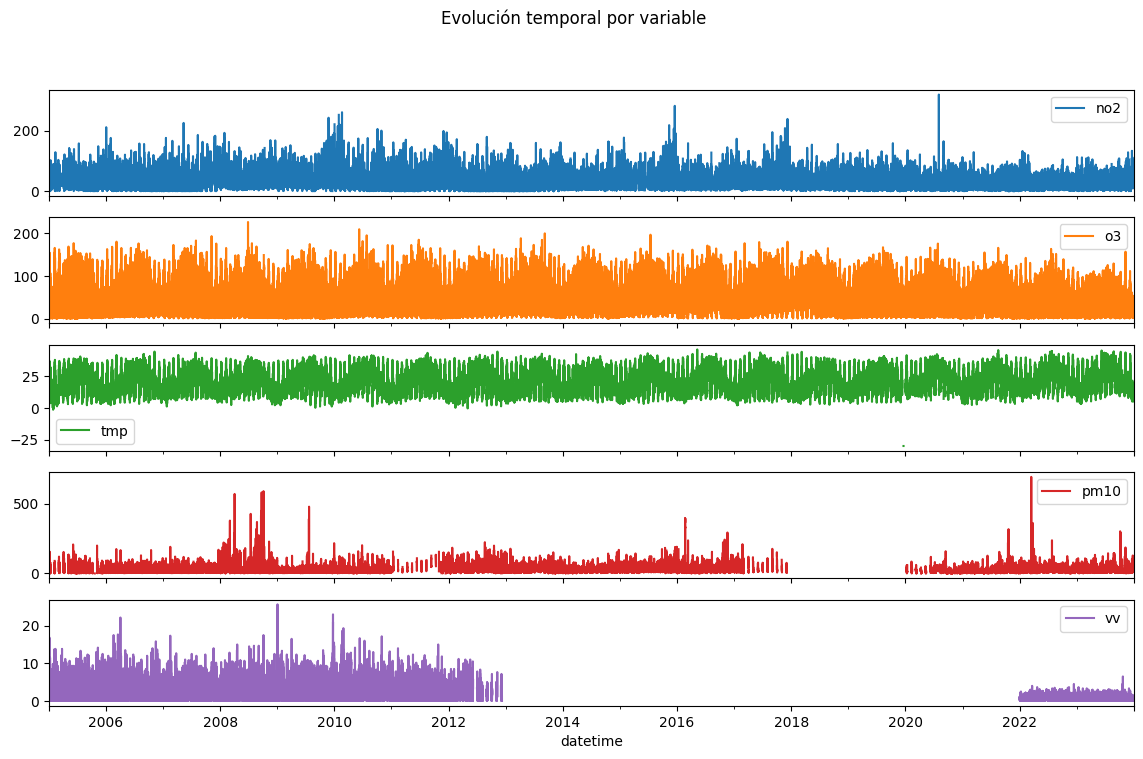

In [14]:
# --- 2. Convertir la columna datetime a tipo fecha ---
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# --- 3. Definir columna temporal como índice ---
df = df.set_index('datetime')

# --- 4. Visualización general ---
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df.index, df['pm10'], label='pm10', alpha=0.8)
plt.plot(df.index, df['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Subgráficos por variable ---
variables = ['no2', 'o3', 'tmp','pm10', 'vv']
df[variables].plot(subplots=True, figsize=(14, 8), sharex=True, title='Evolución temporal por variable')
plt.show()


Mostrando datos desde 2023-12-24 hasta 2023-12-31


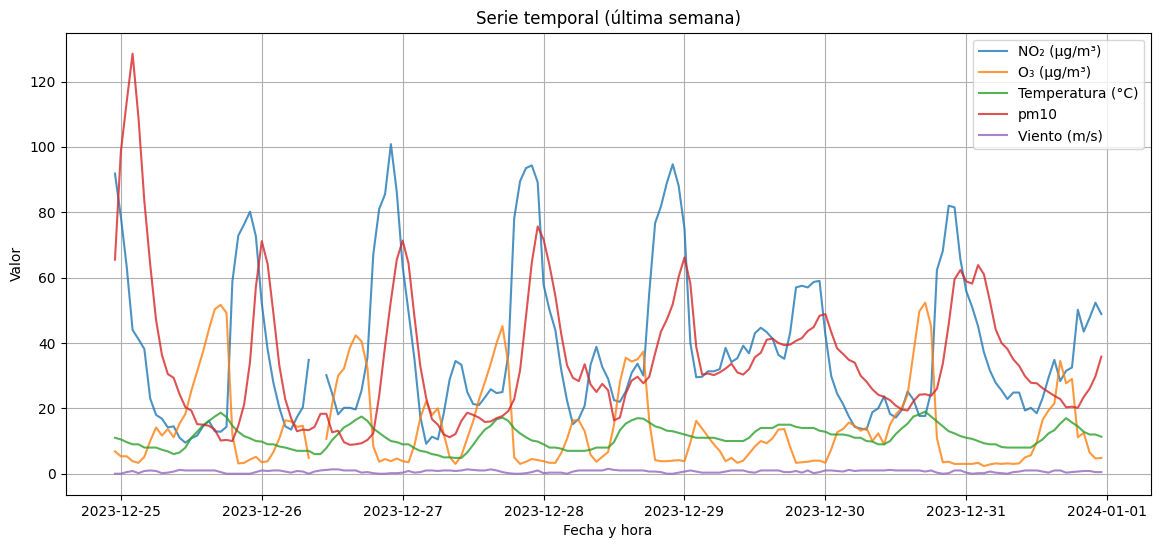

In [55]:
ultima_fecha = df.index.max()
inicio_semana = ultima_fecha - pd.Timedelta(days=7)
df_semana = df.loc[inicio_semana:ultima_fecha]

print(f"Mostrando datos desde {inicio_semana.date()} hasta {ultima_fecha.date()}")

# --- 🔹 Graficar las variables principales ---
plt.figure(figsize=(14, 6))
plt.plot(df_semana.index, df_semana['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_semana.index, df_semana['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_semana.index, df_semana['pm10'], label='pm10', alpha=0.8)
plt.plot(df_semana.index, df_semana['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2005-01-01 00:00:00,2269.0000,18.6667,2.5000,NaN,6.0000,0.3333
2005-01-01 01:00:00,2269.0000,18.6667,2.5000,NaN,6.0000,0.3333
2005-01-01 02:00:00,2024.6667,26.6667,7.5000,NaN,6.6667,1.0000
2005-01-01 03:00:00,2229.3333,19.6667,5.5000,NaN,6.1667,0.3333
2005-01-01 04:00:00,2096.1667,19.5000,4.6667,NaN,5.3333,0.8333
...,...,...,...,...,...,...
2023-12-31 19:00:00,716.8333,50.1667,11.1667,20.1667,14.5000,0.6667
2023-12-31 20:00:00,678.6667,43.5000,12.5000,23.5000,12.8333,0.8333
2023-12-31 21:00:00,758.8333,47.6667,6.5000,26.0000,12.0000,0.8333


In [18]:
ultima_fecha = df.index.max()
inicio_semana = ultima_fecha - pd.Timedelta(days=365)
df_year = df.loc[inicio_semana:ultima_fecha]

In [19]:
df_year.isna().sum()

co       80
no2     245
o3       63
pm10     56
tmp       1
vv        1
dtype: int64

### 2005 a 2010

Timestamp('2005-01-01 00:00:00')

In [34]:


df_4 = df.truncate(before = '2006-01-01 00:00:00', after= '2010-12-31 23:00:00')

In [38]:
df_4

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2006-01-01 00:00:00,183.0000,9.0000,48.1667,4.6667,13.0000,1.3333
2006-01-01 01:00:00,191.1667,7.8333,51.6667,5.0000,13.0000,2.6667
2006-01-01 02:00:00,204.0000,12.8333,48.6667,9.6667,13.0000,3.3333
2006-01-01 03:00:00,243.0000,9.8333,49.0000,11.5000,13.0000,2.3333
2006-01-01 04:00:00,252.8333,10.5000,44.6667,7.6667,12.5000,1.0000
...,...,...,...,...,...,...
2010-12-31 19:00:00,416.5000,12.0000,62.8333,9.8333,16.0000,3.5000
2010-12-31 20:00:00,460.3333,25.3333,48.5000,8.8333,15.6667,3.5000
2010-12-31 21:00:00,432.0000,34.6667,43.1667,7.3333,15.0000,3.1667


In [37]:
df_4.isna().sum(), df_4.shape

(co      2401
 no2     3041
 o3      1701
 pm10    2803
 tmp      722
 vv       789
 dtype: int64,
 (43824, 6))

In [40]:
# 1.3 comprobar frecuencia y huecos
print("Frecuencia inferida:", pd.infer_freq(df_4.index))
# mostrar primeras/últimas filas y huecos
print(df_4.head())
print(df_4.tail())


Frecuencia inferida: h
                           co      no2       o3     pm10   tmp      vv
datetime                                                              
2006-01-01 00:00:00  183.0000   9.0000  48.1667   4.6667  13.0  1.3333
2006-01-01 01:00:00  191.1667   7.8333  51.6667   5.0000  13.0  2.6667
2006-01-01 02:00:00  204.0000  12.8333  48.6667   9.6667  13.0  3.3333
2006-01-01 03:00:00  243.0000   9.8333  49.0000  11.5000  13.0  2.3333
2006-01-01 04:00:00  252.8333  10.5000  44.6667   7.6667  12.5  1.0000
                           co      no2       o3     pm10      tmp      vv
datetime                                                                 
2010-12-31 19:00:00  416.5000  12.0000  62.8333   9.8333  16.0000  3.5000
2010-12-31 20:00:00  460.3333  25.3333  48.5000   8.8333  15.6667  3.5000
2010-12-31 21:00:00  432.0000  34.6667  43.1667   7.3333  15.0000  3.1667
2010-12-31 22:00:00  426.6667  22.8333  51.6667  19.1667  15.0000  2.1667
2010-12-31 23:00:00  398.8333  11.83

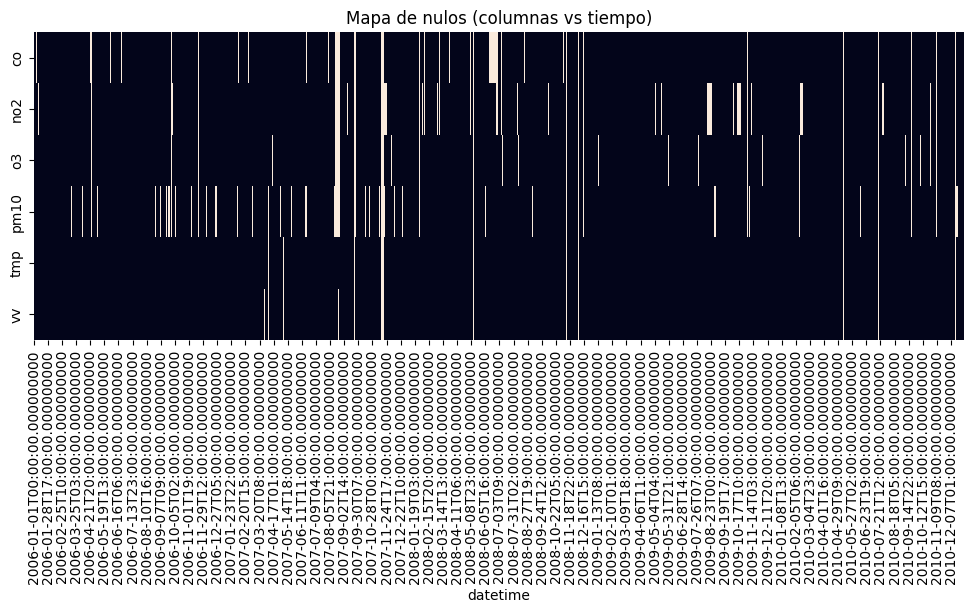

In [41]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.heatmap(df_4.isna().T, cbar=False)
plt.title('Mapa de nulos (columnas vs tiempo)')
plt.show()

In [49]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# 4.1: Imputación rápida para huecos pequeños con interpolación por columna
df_interp = df_4.copy()
for col in df_interp.columns:
    # interpolación temporal; limit=6 -> no imputa tramos mayores a 6 horas (ajusta)
    df_interp[col] = df_interp[col].interpolate(method='time', limit=6)


print(df_interp.isna().sum())

# 4.2: Para huecos más largos, usar IterativeImputer (e.g. BayesianRidge pred) o KNN
# crear features de tiempo para ayudar a imputar

df_imp = df_interp.copy()
df_imp['hour'] = df_imp.index.hour
df_imp['dayofweek'] = df_imp.index.dayofweek
df_imp['month'] = df_imp.index.month

# Imputador iterativo (puede ser más robusto que KNN)
imp = IterativeImputer(random_state=0, max_iter=10)
cols = ['co','no2','o3','pm10','tmp','vv','hour','dayofweek','month']
imputed = imp.fit_transform(df_imp[cols])
df_imputed = pd.DataFrame(imputed, index=df_imp.index, columns=cols)

# Volver a asignar sólo las variables originales (no los features)

co      1750
no2     2270
o3      1125
pm10    2016
tmp      542
vv       604
dtype: int64


In [50]:
df_imputed.isna().sum()

co           0
no2          0
o3           0
pm10         0
tmp          0
vv           0
hour         0
dayofweek    0
month        0
dtype: int64

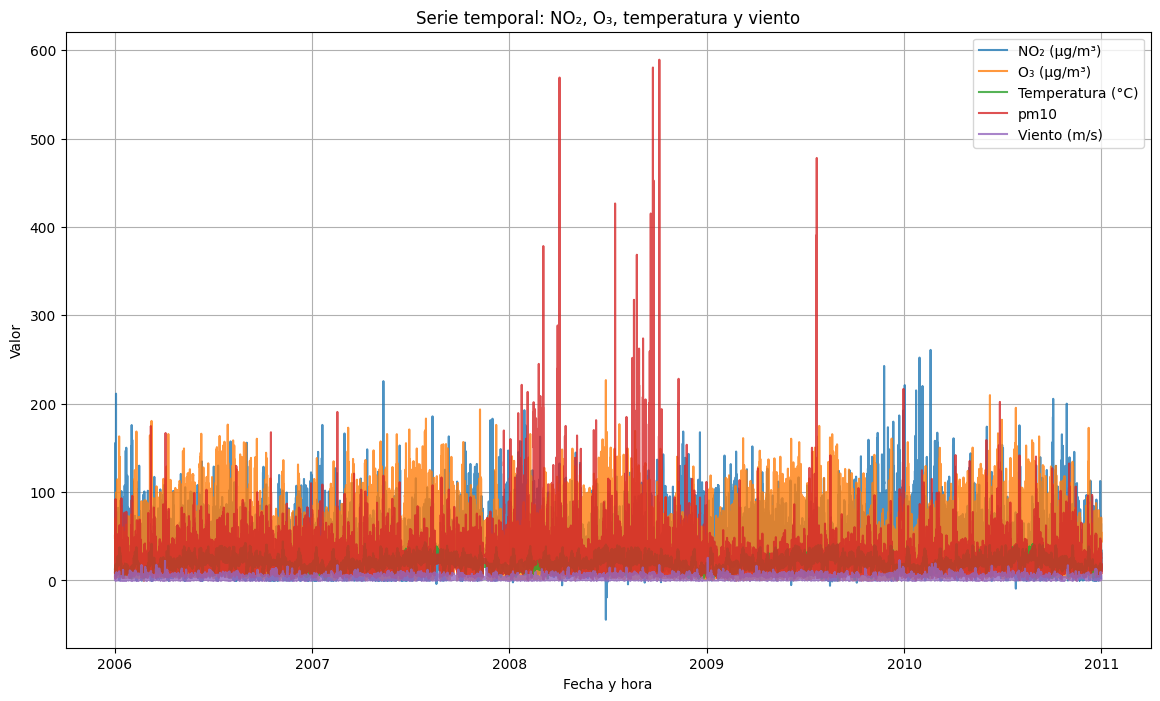

In [52]:
plt.figure(figsize=(14, 8))
plt.plot(df_imputed.index, df_imputed['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['pm10'], label='pm10', alpha=0.8)
plt.plot(df_imputed.index, df_imputed['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

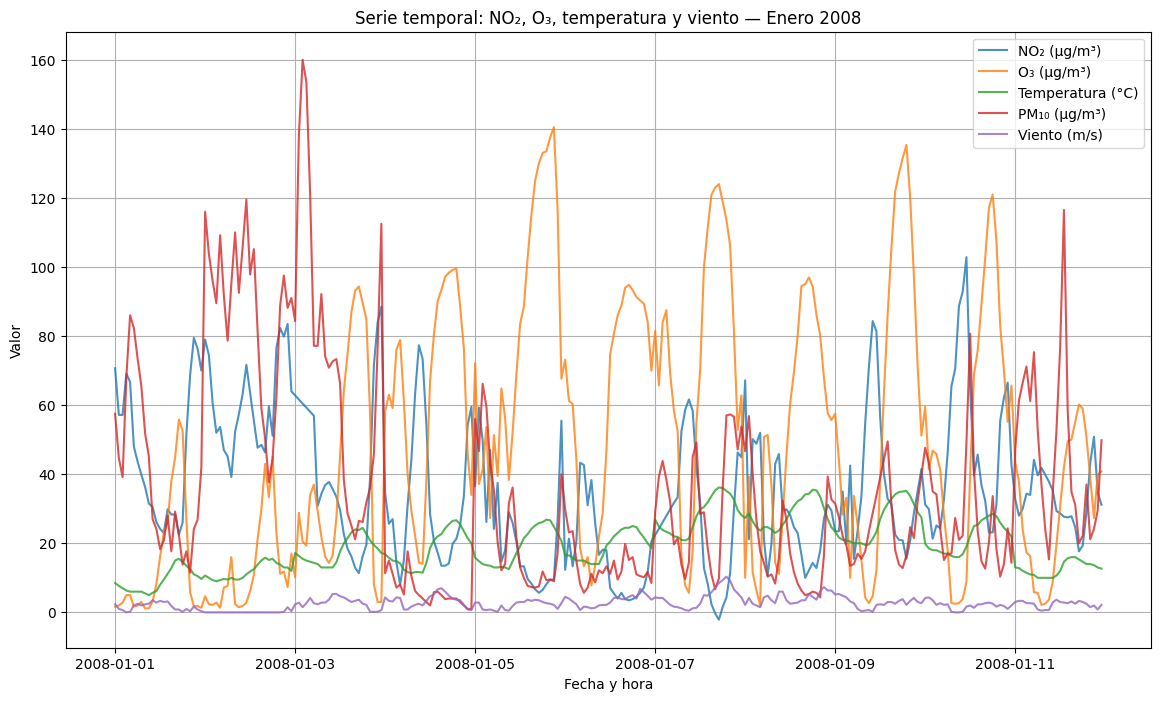

In [54]:
df_mes = df_imputed.loc['2008-01-01':'2008-01-11']

plt.figure(figsize=(14, 8))
plt.plot(df_mes.index, df_mes['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_mes.index, df_mes['pm10'], label='PM₁₀ (µg/m³)', alpha=0.8)
plt.plot(df_mes.index, df_mes['vv'], label='Viento (m/s)', alpha=0.8)

plt.title('Serie temporal: NO₂, O₃, temperatura y viento — Enero 2008')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
def cap_outliers(s, k=1.5):
    q1 = df_imputed[s].quantile(0.25)
    q3 = df_imputed[s].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    outliers = df_imputed[(df_imputed[s] < lower) | (df_imputed[s] > upper)]
    print('Outliers en '+str(s)+ ' ' + str(len(outliers)))

cols_to_check = ['no2', 'pm10', 'tmp', 'vv', 'o3']
for col in cols_to_check:
    cap_outliers(col)


Outliers en no2 1426
Outliers en pm10 2791
Outliers en tmp 129
Outliers en vv 1504
Outliers en o3 113


### NORMALIZACION

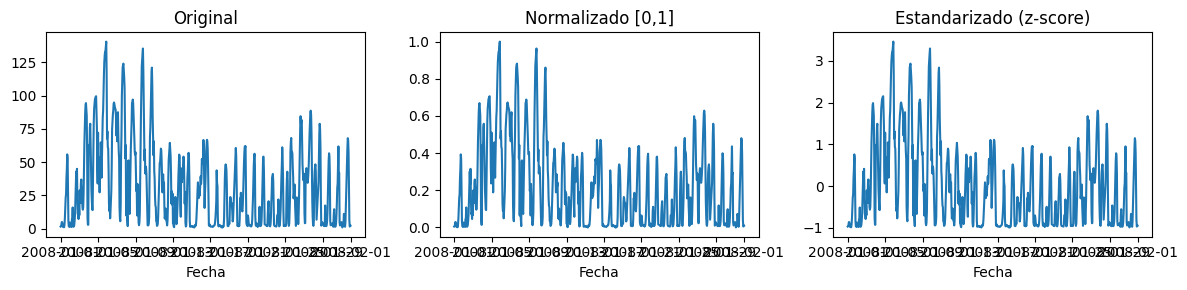

,o3,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,32.096034,0.222911,9.550306e-17
std,31.339865,0.224659,1.000673e+00
min,1.000000,0.000000,-9.928873e-01
25%,3.791650,0.020012,-9.037507e-01
50%,23.083350,0.158304,-2.877724e-01
75%,51.333300,0.360812,6.142403e-01
max,140.500000,1.000000,3.461307e+00


In [70]:
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

df_mes = df_imputed.loc['2008-01-01':'2008-01-31']
# Trabajamos sobre una copia para no tocar df_week
df = df_mes.copy()
columna = 'o3'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

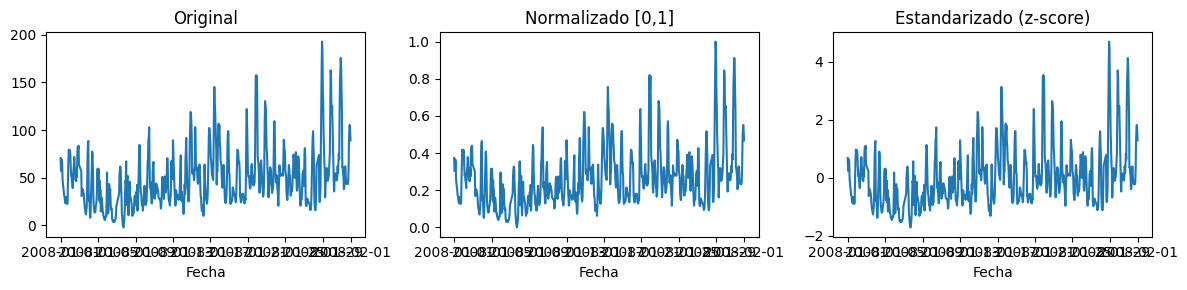

,no2,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,49.814604,0.266655,-2.292073e-16
std,30.428786,0.156209,1.000673e+00
min,-2.128549,0.000000,-1.708188e+00
25%,28.333300,0.156379,-7.064283e-01
50%,44.166700,0.237661,-1.857354e-01
75%,62.705025,0.332829,4.239108e-01
max,192.666700,1.000000,4.697795e+00


In [71]:
columna = 'no2'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

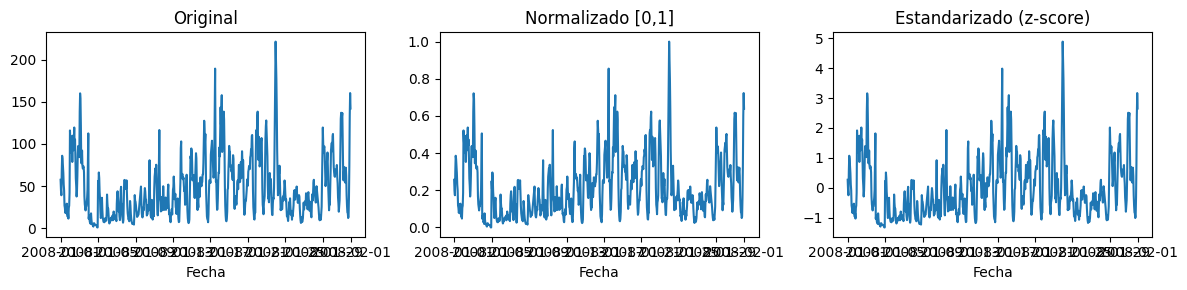

,pm10,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,48.182526,0.214142,-3.820122e-17
std,35.454571,0.160913,1.000673e+00
min,1.000000,0.000000,-1.331683e+00
25%,21.166700,0.091528,-7.624969e-01
50%,39.027783,0.172592,-2.583842e-01
75%,67.333300,0.301059,5.405130e-01
max,221.333300,1.000000,4.887022e+00


In [72]:
columna = 'pm10'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

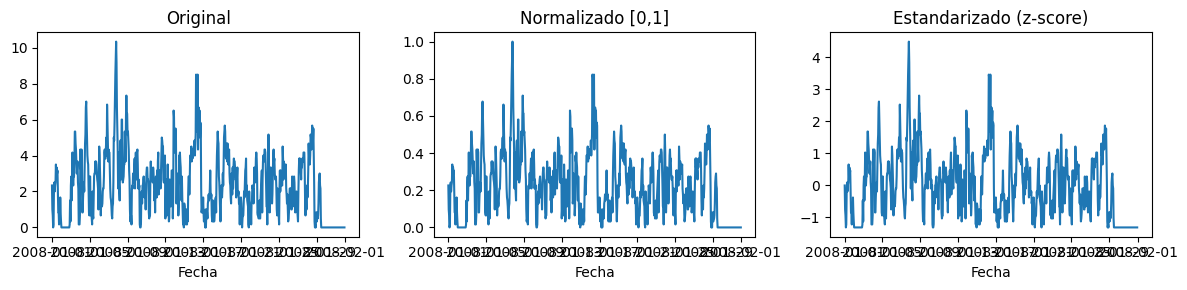

,vv,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,2.346551,0.227086,1.337043e-16
std,1.783418,0.172589,1.000673e+00
min,0.000000,0.000000,-1.316645e+00
25%,0.833300,0.080642,-8.490823e-01
50%,2.166700,0.209681,-1.009140e-01
75%,3.500000,0.338711,6.471982e-01
max,10.333300,1.000000,4.481350e+00


In [73]:
columna = 'vv'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

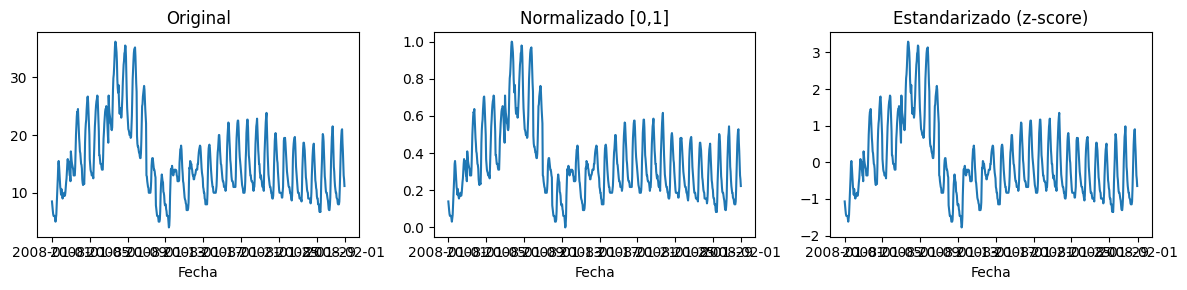

,tmp,Nivel_normalizado,Nivel_estandarizado
count,744.000000,744.000000,7.440000e+02
mean,15.275538,0.350534,2.101067e-16
std,6.345595,0.197272,1.000673e+00
min,4.000000,0.000000,-1.778103e+00
25%,10.666700,0.207255,-7.267937e-01
50%,13.916650,0.308289,-2.142907e-01
75%,18.708350,0.457254,5.413395e-01
max,36.166700,1.000000,3.294445e+00


In [74]:
columna = 'tmp'   # cambia si tu variable principal tiene otro nombre

# --- Normalización [0,1] ---
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
df['Nivel_normalizado'] = scaler_minmax.fit_transform(df[[columna]])

# --- Estandarización (z-score) ---
scaler_std = StandardScaler()
df['Nivel_estandarizado'] = scaler_std.fit_transform(df[[columna]])

# --- Comparación visual (original vs transformaciones) ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axes[0].plot(df.index, df[columna]);                 axes[0].set_title('Original')
axes[1].plot(df.index, df['Nivel_normalizado']);     axes[1].set_title('Normalizado [0,1]')
axes[2].plot(df.index, df['Nivel_estandarizado']);   axes[2].set_title('Estandarizado (z-score)')
for ax in axes: ax.set_xlabel('Fecha')
plt.tight_layout(); plt.show()

# --- Comparación numérica rápida ---
display(df[[columna, 'Nivel_normalizado', 'Nivel_estandarizado']].describe())

### MODELO BASE SIN EXOGENAS:

In [75]:
y = df_mes['o3'].astype(float)

In [76]:
y

datetime
2008-01-01 00:00:00     1.6667
2008-01-01 01:00:00     2.0000
2008-01-01 02:00:00     2.8333
2008-01-01 03:00:00     5.0000
2008-01-01 04:00:00     5.0000
                        ...   
2008-01-31 19:00:00    32.6667
2008-01-31 20:00:00     6.5000
2008-01-31 21:00:00     1.6667
2008-01-31 22:00:00     2.1667
2008-01-31 23:00:00     2.3333
Name: o3, Length: 744, dtype: float64

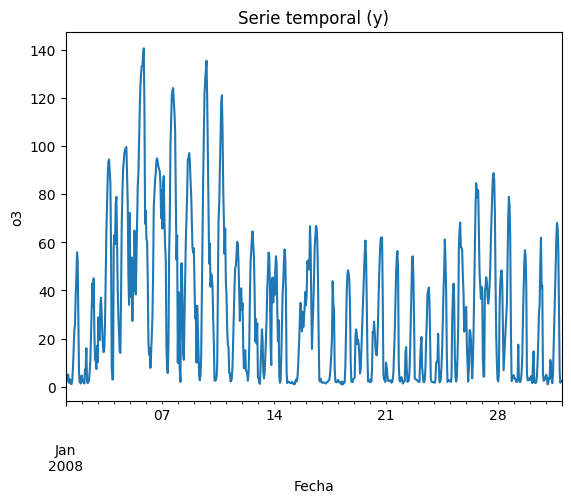

In [77]:
y.plot(title='Serie temporal (y)'); plt.xlabel('Fecha'); plt.ylabel('o3'); plt.show()

In [ ]:
# 5) Split y CV
H = 26  # tamaño del tramo de validación
H = int(min(H, len(y) - 5))  # por si la serie fuese muy corta
y_train = y.iloc[:-H].copy()
y_valid = y.iloc[-H:].copy()

# Reasignar frecuencia explícita si la conocemos
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print('⚠️ Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')

print(f'Freq: {freq}')
print(f'Train: {y_train.index[0].date()} → {y_train.index[-1].date()} (n={len(y_train)})')
print(f'Valid: {y_valid.index[0].date()} → {y_valid.index[-1].date()} (n={len(y_valid)})')

cv = TimeSeriesFold(
    steps=H,
    initial_train_size=len(y) - H,
    fixed_train_size=True
)
cv
